In [4]:
%config Completer.use_jedi = False

In [43]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer


In [6]:
movie_reviews=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [7]:
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [8]:
movie_reviews.shape

(50000, 2)

In [9]:
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

In [10]:
movie_reviews['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [11]:
# Sample
movie_reviews['review'][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

## Data preprocessing

In [12]:
def preprocess_text(sen):
    # remove html tags
    sentence = remove_tags(sen)
    
    # remove punctuation and numbers
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    
    #  remove single charachters
    sentence = re.sub('\s+[^a-zA-Z]\s+',' ',sentence)
    
    # remove multiple spaces
    sentence = re.sub('\s+',' ',sentence)
    
    return sentence

In [13]:
TAG_RE=re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [14]:
reviwe = []
sentences=list(movie_reviews['review'])
for sen in sentences:
    reviwe.append(preprocess_text(sen))


In [15]:
# after apply cleaning
reviwe[4]

'Petter Mattei s Love in the Time of Money is a visually stunning film to watch Mr Mattei offers us a vivid portrait about human relations This is a movie that seems to be telling us what money power and success do to people in the different situations we encounter This being a variation on the Arthur Schnitzler s play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has a sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits A big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounter The acti

convert labels of sentement to numbers

In [16]:
converted=movie_reviews['sentiment']

converted= np.array(list(map(lambda x: 1 if x=='positive' else 0, converted)))

## Split the Data

In [17]:
review_train, review_test, converted_train, converted_test =train_test_split(reviwe,converted,test_size=0.2,random_state=42)

**Use Tokenization**

In [18]:
tokenizer= Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)

review_train=tokenizer.texts_to_sequences(review_train)
review_test=tokenizer.texts_to_sequences(review_test)

**Use Padding**

In [19]:
vocab_size=len(tokenizer.word_index)+1
maxlen=100
review_train=pad_sequences(review_train,padding='post',maxlen=maxlen)
review_test=pad_sequences(review_test,padding='post',maxlen=maxlen)

**Use GloVe Word Embedding**

In [20]:
#/kaggle/input/starter-glove-txt-df668cc8-6
embedding_dictionry=dict()
glove_file= open('/kaggle/input/glove/glove.6B.100d.txt',encoding='utf8')

for line in glove_file:
    records=line.split()
    word=records[0]
    vector_dimensions=asarray(records[1:],dtype='float32')
    embedding_dictionry[word] = vector_dimensions
glove_file.close()

In [21]:
embedding_matrix=zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
    embedded_vec=embedding_dictionry.get(word)
    if embedded_vec is not None:
        embedding_matrix[index]=embedded_vec

## Building Nueral Network

In [23]:
model=Sequential()
embedding_layer=Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False )
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,254,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

In [24]:
history =model.fit(review_train,converted_train,batch_size=128, epochs=6, validation_split=0.2,verbose=1)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - acc: 0.6142 - loss: 0.6392 - val_acc: 0.7763 - val_loss: 0.4751
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 186ms/step - acc: 0.7796 - loss: 0.4713 - val_acc: 0.8142 - val_loss: 0.4078
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 186ms/step - acc: 0.8152 - loss: 0.4067 - val_acc: 0.8194 - val_loss: 0.3927
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - acc: 0.8364 - loss: 0.3682 - val_acc: 0.8422 - val_loss: 0.3719
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - acc: 0.8464 - loss: 0.3527 - val_acc: 0.8286 - val_loss: 0.3933
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - acc: 0.8552 - loss: 0.3347 - val_acc: 0.8464 - val_loss: 0.3504


## Model Evaluation

In [25]:
score=model.evaluate(review_test,converted_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - acc: 0.8411 - loss: 0.3616


In [26]:
print('Test Score',score[0])
print('Test Accuracy',score[1])

Test Score 0.35417401790618896
Test Accuracy 0.8457000255584717


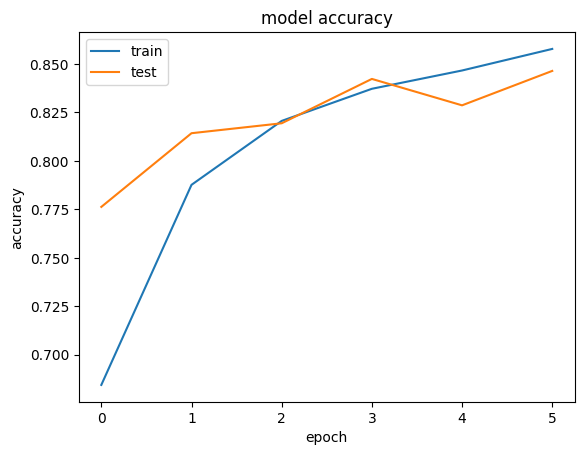

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()

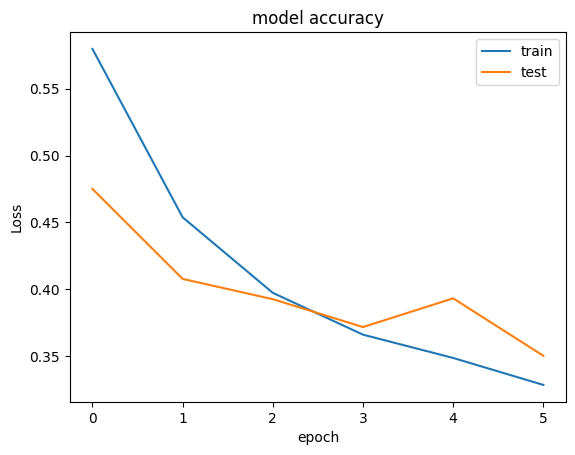

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()

## Try a random review

In [56]:
instance=tokenizer.texts_to_sequences(reviwe[60])

flat_list=[]
for sublist in instance:
    for item in sublist:
        flat_list.append(item)
        
flat_list=[flat_list]
print(converted[60])

0


In [57]:
instance=pad_sequences(flat_list, padding='post', maxlen=maxlen)


In [58]:
instance

array([[   3,  951,   22, 1232,  733,   12,   12,  733,   12,    3, 1232,
         733, 3695, 1082,    9,   22,  733, 1080, 1082, 1487, 1487, 4066,
           9, 1487,   22, 1959,  733,    9, 1232,  667, 1860, 1487, 1860,
           3, 4066,   12,    3, 1487,  201,   12,    9,   22,   22,    9,
        1487, 1176, 1959,  733, 1232,  733,    9,  951,    3, 1487,   22,
        1959,    9, 1487, 1164,  667, 1080, 1487, 1082,  138,  733, 1232,
         667, 1082,   12,   12,  951,  733, 1487,    3, 1232,    9,  667,
          12,   22, 1959,    3,   22, 1860,  667, 1082, 1253,  201, 1959,
           3, 1858,  733,  472,  733,  733, 1487,    3, 1232,    9,  667,
          22]], dtype=int32)

In [59]:
pred=model.predict(instance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [61]:
round(pred[0][0])

0

In [85]:
def prepare_text(inputs_):
    
    instance=tokenizer.texts_to_sequences(inputs_)
    flat_list=[]
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list=[flat_list]
    instance=pad_sequences(flat_list, padding='post', maxlen=maxlen)
    
    return instance


In [84]:
input='i do not like this movie because it have a lot of boring scene'
input=prepare_text(input)

In [87]:
pred=model.predict(input)
round(pred[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [96]:
input='i like this movie because it have a lot of fun'
input=prepare_text(input)

In [97]:
pred=model.predict(input)
round(pred[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1